In [1]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd
import seaborn as sns

from PIL import Image
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import torch

from PIL import Image
from torch.utils.data import DataLoader, Dataset

import warnings
warnings.filterwarnings('ignore')

c:\Users\korea\anaconda3\envs\py39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Local PC로 실습하는 경우 실행 x / 단 작업경로를 LGES2023_Sampling_and_XAI으로 맞춰주기
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/LGES2023_Sampling_and_XAI

In [2]:
def plot_representation(X, y, X_syn=None, y_syn=None, method='real'):
    # 정상 데이터, 이상 데이터 추출
    y_normal, y_anomaly = y[y==0].dropna(), y[y==1].dropna()
    X_normal, X_anomaly = X.loc[list(y_normal.index), :], X.loc[list(y_anomaly.index), :]
    
    # Sampling 결과 비교
    # method == 'real': 실제 데이터만 시각화
    # method != 'real': Sampling 결과와 실제 데이터 시각화 비교
    if method.lower() != 'real':
        fig = plt.figure(figsize=(16, 8))
        ax1 = fig.add_subplot(1, 2, 1)
    else:
        fig = plt.figure(figsize=(8, 8))
        ax1 = fig.add_subplot(1, 1, 1)

    # create_dataset 으로 생성된 데이터 시각화
    # 실제 데이터 사용시 2차원으로 축소 후 본 함수 사용
    # column 명을 정확히 기입해주어야함
    ax1.scatter(X_normal['X1'], X_normal['X2'], alpha=0.3, c='blue', label='Normal')
    ax1.scatter(X_anomaly['X1'], X_anomaly['X2'], alpha=0.3, c='red', label='Anomaly')
    
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.get_xaxis().tick_bottom()
    ax1.get_yaxis().tick_left()

    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
    plt.legend()
    plt.tight_layout()
    plt.title('Real', fontsize=20)

    if X_syn is not None:
        ax2 = fig.add_subplot(1, 2, 2)
        y_syn_normal, y_syn_anomaly = y_syn[y_syn==0].dropna(), y_syn[y_syn==1].dropna()
        X_syn_normal, X_syn_anomaly = X_syn.loc[list(y_syn_normal.index), :], X_syn.loc[list(y_syn_anomaly.index), :]

        ax2.scatter(X_syn_normal['X1'], X_syn_normal['X2'], alpha=0.3, c='blue', label='Normal')
        ax2.scatter(X_syn_anomaly['X1'], X_syn_anomaly['X2'], alpha=0.3, c='red', label='Anomaly')

        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.get_xaxis().tick_bottom()
        ax2.get_yaxis().tick_left()

        plt.xlim((-5, 5))
        plt.ylim((-5, 5))
        plt.legend()
        plt.tight_layout()
        plt.title(method, fontsize=20)
        
    plt.show()

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    혼동 행렬을 시각화하는 함수입니다.

    인자:
    cm : numpy.ndarray
        혼동 행렬
    classes : list
        클래스 레이블의 이름을 포함하는 리스트
    normalize : bool, optional (default=False)
        True로 설정하면 혼동 행렬을 정규화합니다.
    title : str, optional (default='Confusion Matrix')
        시각화의 제목
    cmap : matplotlib colormap, optional (default=plt.cm.Blues)
        시각화에 사용할 컬러맵

    반환값:
    None
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
def create_dataset(n_samples=2000,
                weights=(0.8, 0.2),
                n_classes=2,
                class_sep=1,
                n_cluster=1,
                random_state=0):
    df = make_classification(n_samples=n_samples, n_features=2,
                            n_informative=2, n_redundant=0, n_repeated=0,
                            n_classes=n_classes,
                            n_clusters_per_class=n_cluster,
                            weights=list(weights),
                            class_sep=class_sep, random_state=random_state)
    
    X = pd.DataFrame(df[0], columns=['X1', 'X2'])
    y = pd.DataFrame(df[1], columns=['y'])
    return X, y

def calculate_classification_metrics(true_labels, predicted_labels):
    """
    true값과 pred값을 입력받아 accuracy, precision, recall, micro F1-score, macro F1-score를 계산하고 출력하는 함수입니다.

    인자:
    true_labels : array-like of shape (n_samples,)
        실제 레이블
    predicted_labels : array-like of shape (n_samples,)
        예측된 레이블
    """
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")
    
    return accuracy, precision, recall, f1

# Pytorch Sampler

DataLoader parameters

https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

Sampler는 dataloader가 dataset에 주는 index를 조절해주는 역할

https://pytorch.org/docs/stable/data.html#torch.utils.data.Sampler

1. SequentialSampler : index를 순서대로 호출 -> shuffle = False와 같음

2. RandomSampler : index를 랜덤하게 호출 -> shuffle = True와 같음

3. SubsetRandomSampler : 전체 index 중 특정 부분(subset)만 랜덤하게 호출 (train/test/valid로 활용 가능)

4. WeightedRandomSampler : 각 index가 뽑힐 확률을 통해서 랜덤하게 index 호출 -> batch마다 class가 균등하게 샘플링 되도록 유도 가능

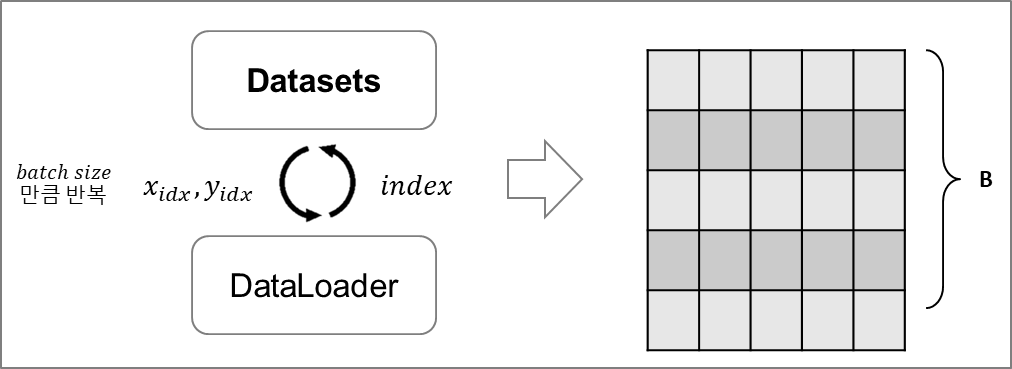

In [3]:
Image.open('./imgs/img9.png')

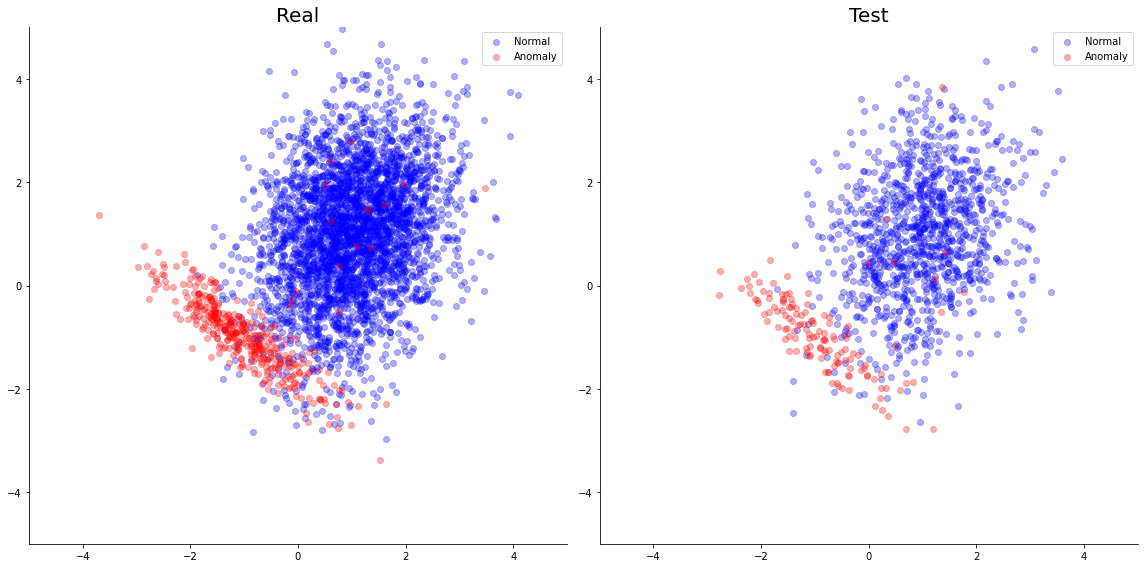

In [4]:
X_syn, y_syn = create_dataset(n_samples=5000, weights=(0.9, 0.1), n_cluster=1, random_state=711)
X_train, X_test, y_train, y_test = train_test_split(X_syn,y_syn, random_state=2023)
plot_representation(X_train, y_train, X_test, y_test, method='Test')

In [5]:
y_train.value_counts()

y
0    3361
1     389
dtype: int64

In [6]:
print(f'{3361/389:.2f}:1')

8.64:1


In [7]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        
        self.X = X.to_numpy()
        self.y = y.to_numpy()
        
    def __getitem__(self, index):
        X = torch.FloatTensor(self.X[index])
        y = torch.LongTensor(self.y[index])
        return X, y
    
    def __len__(self):
        return len(self.y)
    

In [8]:
mydataset = CustomDataset(X_train, y_train)

In [9]:
mydataset.X.shape

(3750, 2)

## RandomSampler

In [10]:
from torch.utils.data import RandomSampler

In [11]:
random_sampler = RandomSampler(data_source=mydataset)
dataloader = DataLoader(dataset=mydataset,
                        batch_size=375,
                        sampler=random_sampler,
                        drop_last=True)

Average : 8.9388


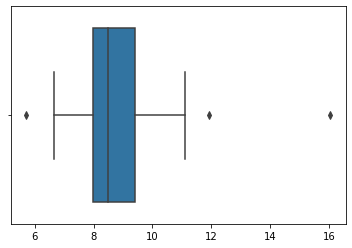

In [12]:
ratio = []

for epoch in range(3):
    for (X,y) in dataloader:
        num_class1 = (y==0).sum().item()
        num_class2 = (y==1).sum().item()
        ratio.append(num_class1/num_class2)

sns.boxplot(x=ratio)
print(f'Average : {np.mean(ratio):.4f}')

## WeightedRandomSampler

In [13]:
from torch.utils.data import WeightedRandomSampler

In [14]:
class_counts = y_train.value_counts().to_list()
print(class_counts)
num_samples = sum(class_counts)
labels = y_train.to_numpy().squeeze(1)

#클래스별 가중치 부여 [3750/3361, 3750/389] => class 1에 가중치 높게 부여하게 됨
class_weights = [num_samples / class_counts[i] for i in range(len(class_counts))] 
print(class_weights)

[3361, 389]
[1.1157393632847368, 9.640102827763496]


In [15]:
# 해당 데이터의 label에 해당되는 가중치
weights = [class_weights[labels[i]] for i in range(int(num_samples))] #해당 레이블마다의 가중치 비율
sampler = WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))

In [16]:
dataloader = DataLoader(dataset=mydataset,
                        batch_size=375,
                        sampler=sampler,
                        drop_last=True)

Average : 1.0259


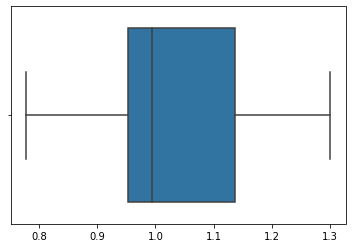

In [17]:
ratio = []

for epoch in range(3):
    for (X,y) in dataloader:
        num_class1 = (y==0).sum().item()
        num_class2 = (y==1).sum().item()
        ratio.append(num_class1/num_class2)

sns.boxplot(x=ratio)
print(f'Average : {np.mean(ratio):.4f}')